# train the best stacking model 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,StackingRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    LabelEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore")

In [2]:
# !pip install optuna xgboost lightgbm mlflow dagshub

import mlflow
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

In [3]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [4]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [5]:
mlflow.set_experiment("Exp 6 - stacking final ensemble model rf+lgbm->lr ")

2025/07/01 00:47:10 INFO mlflow.tracking.fluent: Experiment with name 'Exp 6 - stacking final ensemble model rf+lgbm->lr ' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/42c9bc1b3ad244eb952a986715a32ca5', creation_time=1751310130845, experiment_id='6', last_update_time=1751310130845, lifecycle_stage='active', name='Exp 6 - stacking final ensemble model rf+lgbm->lr ', tags={}>

In [6]:
from sklearn import set_config

set_config(transform_output="pandas")

In [7]:
df = pd.read_csv("../data/processed/cleaned_mvd.csv")
df.drop(columns="Unnamed: 0", axis=1, inplace=True)

In [8]:
X = df.drop(columns="time_taken", axis=1)
y = df["time_taken"]

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [11]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 7204 to 15795
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  30156 non-null  float64
 1   ratings              30156 non-null  float64
 2   weather              30156 non-null  object 
 3   traffic              30156 non-null  object 
 4   vehicle_condition    30156 non-null  int64  
 5   type_of_order        30156 non-null  object 
 6   type_of_vehicle      30156 non-null  object 
 7   multiple_deliveries  30156 non-null  float64
 8   festival             30156 non-null  object 
 9   city_type            30156 non-null  object 
 10  is_weekend           30156 non-null  int64  
 11  pickup_time_minutes  30156 non-null  float64
 12  order_time_of_day    30156 non-null  object 
 13  distance             30156 non-null  float64
 14  distance_type        30156 non-null  object 
dtypes: float64(5), int64(2), object(8)
mem

## Preprocessing


In [12]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")


pre_processing_pipeline = Pipeline(
    steps=[
        # ("simple_imputer",simple_imputer),
        ("preprocess", preprocessor)
        # ("knn_imputer",knn_imputer)
    ]
)

pre_processing_pipeline

,steps,"[('preprocess', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,3
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [14]:
df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,33,0,10.0,night,16.600272,very_long
37691,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
37692,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
37693,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [15]:
X_train_trans = pre_processing_pipeline.fit_transform(xtrain)
X_test_trans = pre_processing_pipeline.transform(xtest)
pt = PowerTransformer()
y_train_pt = pt.fit_transform(ytrain.values.reshape(-1, 1))
y_test_pt = pt.transform(ytest.values.reshape(-1, 1))

In [16]:
X_test_trans.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,is_weekend_1,traffic,distance_type,vehicle_condition,multiple_deliveries
37469,0.157895,0.84,1.0,0.239096,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0,0.0
33249,0.526316,0.80,0.5,0.476360,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,1.0
19970,0.368421,0.68,0.5,0.545261,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0,1.0
4405,0.789474,0.96,0.5,0.484974,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0,1.0
24929,0.157895,0.96,0.5,0.623770,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0,1.0


In [17]:
X_train_trans.shape

(30156, 25)

<Axes: >

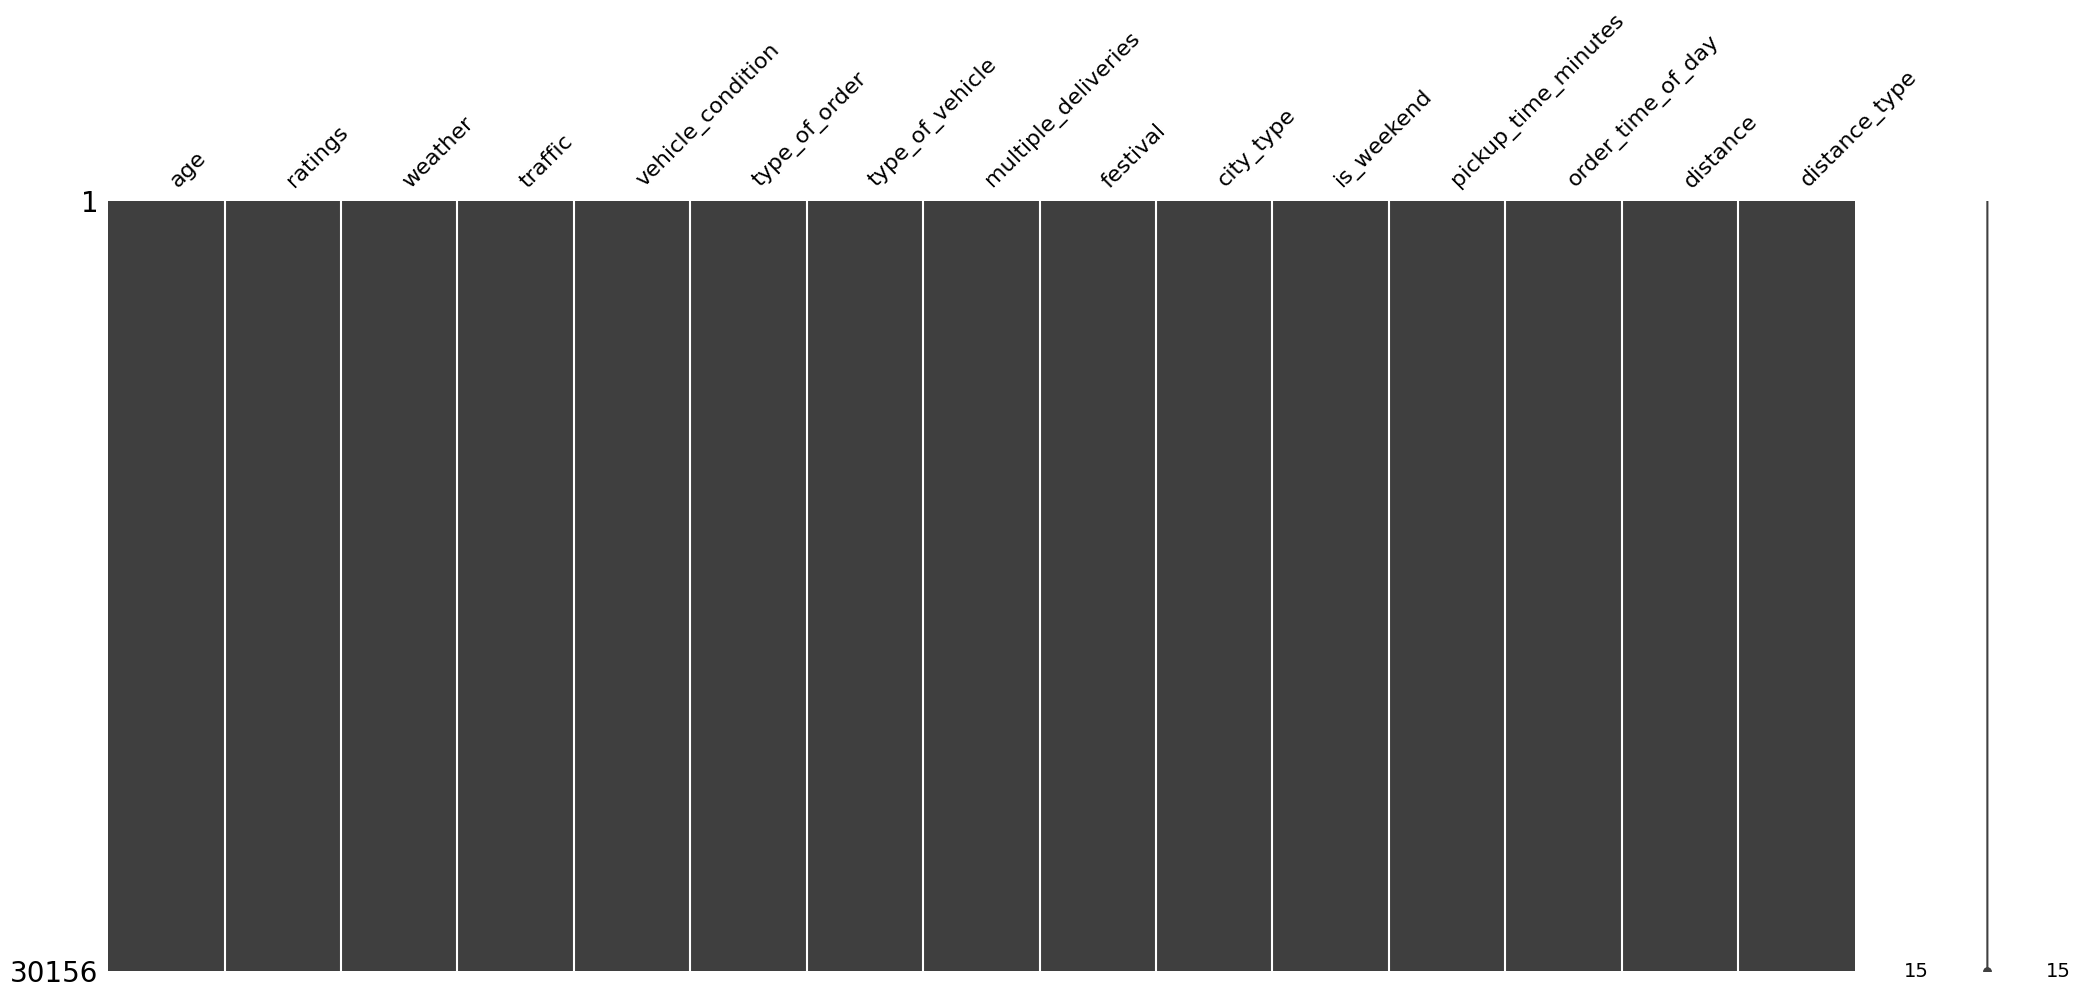

In [18]:
msno.matrix(xtrain)

In [20]:

best_rf_params = {'n_estimators': 138,
 'criterion': 'squared_error',
 'max_depth': 28,
 'max_features': None,
 'min_samples_split': 9,
 'min_samples_leaf': 6,
 'max_samples': 0.9732465926878385}

best_lgbm_params = {'n_estimators': 72,
 'max_depth': 9,
 'learning_rate': 0.586415155400763,
 'subsample': 0.9019313990739353,
 'min_child_weight': 20,
 'min_split_gain': 0.013654097110983532,
 'reg_lambda': 66.64570304778138}

best_rf = RandomForestRegressor(**best_rf_params)
best_lgbm = LGBMRegressor(**best_lgbm_params)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [22]:

stacking_reg = StackingRegressor(
    estimators=[("rf", best_rf), ("lgbm", best_lgbm)],
    final_estimator=lr,
    cv=5,
    n_jobs=-1,
)


model = TransformedTargetRegressor(regressor=stacking_reg, transformer=pt)

model.fit(X_train_trans, ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

,regressor,"StackingRegre...(), n_jobs=-1)"
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,True
,n_estimators,138
,criterion,'squared_error'
,max_depth,28
,min_samples_split,9
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0


In [29]:
model.get_params

<bound method BaseEstimator.get_params of TransformedTargetRegressor(regressor=StackingRegressor(cv=5,
                                                       estimators=[('rf',
                                                                    RandomForestRegressor(max_depth=28,
                                                                                          max_features=None,
                                                                                          max_samples=0.9732465926878385,
                                                                                          min_samples_leaf=6,
                                                                                          min_samples_split=9,
                                                                                          n_estimators=138)),
                                                                   ('lgbm',
                                                                    LGBMRegressor

In [24]:
from sklearn.model_selection import cross_val_score

In [ ]:

y_train_pred = model.predict(X_train_trans)
y_test_pred = model.predict(X_test_trans)


train_mae = mean_absolute_error(ytrain, y_train_pred)
test_mae = mean_absolute_error(ytest, y_test_pred)


train_r2 = r2_score(ytrain, y_train_pred)
test_r2 = r2_score(ytest, y_test_pred)


cv_scores = cross_val_score(
    model, X_train_trans, ytrain, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 20104, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [27]:
-cv_scores

array([3.07766321, 3.08846381, 3.06565754])

In [31]:

with mlflow.start_run():
    mlflow.set_tag("model", "stacking regressor")

    mlflow.log_params(stacking_reg.get_params())

    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("cv_score", -(cv_scores.mean()))

    

🏃 View run dazzling-mouse-649 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/6/runs/56d223c15e6942538e6dfcf51444da57
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/6
